# Satellite Location Demo

Timeliness is an important aspect for countless uses of Earth Observation (EO) data. Humanitarians, for example, benefit from imagery immediately before or after an emergency.

Knowing when an image was captured of an area of interested, or when it will be captured next, can help humanitarians better understand where aid is most needed.

This notebook demonstrates how the location of EO satellites can be computed, both in the past and in the future, in an area of interest. This can be used as a proxy of where images were and will be captured. 

These techniques could be combined with those in other notebooks in this repository, such as loading STAC items and calculating how a disaster impacts people, to create automated analysis for past and future disasters.

## Load Libraries and Data

We'll use the [sgp4](https://pypi.org/project/sgp4/) and [skyfield](https://rhodesmill.org/skyfield/) libraries, which help us calculate the position of satellites using complex orbital physics.

In [128]:
from skyfield.api import load, wgs84, Timescale

from datetime import datetime, timedelta, timezone

from lonboard import viz, Map, ScatterplotLayer, basemap, PathLayer
from lonboard.colormap import apply_continuous_cmap
from palettable.colorbrewer.sequential import Purples_9, Oranges_9
from palettable.colorbrewer.diverging import BrBG_9

import geopandas as gpd
import pandas as pd
from shapely import Point, LineString, Polygon

We'll load information about specific satellites from [Celestrak](https://celestrak.org). Due to the complexities of orbital physics, data about satellites needs to be updated frequently is only accurate for about 1 week before and after "epoch".

For this example, we'll calculate the position of Sentinel 2b.

In [2]:
sentinel_2b_url = "https://celestrak.org/NORAD/elements/gp.php?CATNR=42063"

sentinel_2b = load.tle_file(sentinel_2b_url, reload=True, filename="sentinel_2b")

[#################################] 100% sentinel_2b


In [3]:
satellite = sentinel_2b[0]
satellite

<EarthSatellite SENTINEL-2B catalog #42063 epoch 2024-07-11 16:23:36 UTC>

---

## Calculating the position of a satellite

For sudden-onset emergencies, the time immediately before an after an event are the most critical. We can set a time range of +- 1 day from a certain point in time. For the purposes of this notebook, we'll use `now` (the time when the cell is run).

In [4]:
# Calculate the current UTC time (without microseconds), then creating a time range +/- 24h

# load timescale
ts = load.timescale()

# load "ephemeris" (https://rhodesmill.org/skyfield/api.html#planetary-ephemerides)
eph = load('de421.bsp')

now = datetime.now(timezone.utc).replace(microsecond=0)
t1 = now
t2 = now + timedelta(days=2)

To calculate the position of the satellite throughout the time range, we can initiate a timer and then calculate the position at each time step (defined below).

In [5]:
# initiate

timer = t1

df = pd.DataFrame(columns=['satellite', 'timestamp', 'coordinates', 'lng', 'lat', 'daytime'])

rows = []

The `location_iteration` function lodes the geocentric location, calculates the latitude and longitude, converts them to decimal degrees, and saves them as a point coordinate. It also checks if the satellite is sunlit at the time of calculation, which can be used as an approximation of if it is daytime below.

In [6]:
def location_iteration(timer, sat):
    geocentric = sat.at(Timescale.from_datetime(ts, timer))
    lat, lon = wgs84.latlon_of(geocentric)
    longitude = lon.degrees
    latitude = lat.degrees
    daytime = geocentric.is_sunlit(eph)
    coords = Point(longitude, latitude)

    return timer, longitude, latitude, coords, daytime

Then, we can iterate over the time frame. The more frequent the measurements, the slower the calculation takes.

In [7]:
while timer <= t2:
    timer, longitude, latitude, coords, daytime = location_iteration(timer, sentinel_2b[0])

    row = pd.DataFrame({'satellite': satellite.name, 'timestamp': timer, 'coordinates': [coords], 'lng': longitude, 'lat': latitude, 'daytime': daytime}, index=[0])
    rows.append(row)    

    timer += timedelta(seconds=15) # ~13 seconds

df = pd.concat(rows, ignore_index=True)
df["time_string"] = df["timestamp"].dt.strftime('%Y-%m-%d %X')

We can then save this as a geodataframe.

In [8]:
sentinel_2b_gdf = gpd.GeoDataFrame(df, geometry="coordinates")
sentinel_2b_gdf

,satellite,timestamp,coordinates,lng,lat,daytime,time_string
0,SENTINEL-2B,2024-07-12 13:42:56+00:00,POINT (-75.38464 -71.83547),-75.384642,-71.835472,True,2024-07-12 13:42:56
1,SENTINEL-2B,2024-07-12 13:43:11+00:00,POINT (-76.85869 -72.61103),-76.858688,-72.611032,True,2024-07-12 13:43:11
2,SENTINEL-2B,2024-07-12 13:43:26+00:00,POINT (-78.45917 -73.37570),-78.459166,-73.375703,True,2024-07-12 13:43:26
3,SENTINEL-2B,2024-07-12 13:43:41+00:00,POINT (-80.20217 -74.12793),-80.202166,-74.127929,True,2024-07-12 13:43:41
4,SENTINEL-2B,2024-07-12 13:43:56+00:00,POINT (-82.10606 -74.86587),-82.106064,-74.865873,True,2024-07-12 13:43:56
...,...,...,...,...,...,...,...
11516,SENTINEL-2B,2024-07-14 13:41:56+00:00,POINT (-20.90928 71.75638),-20.909281,71.756383,True,2024-07-14 13:41:56
11517,SENTINEL-2B,2024-07-14 13:42:11+00:00,POINT (-22.26571 70.96687),-22.265713,70.966871,True,2024-07-14 13:42:11
11518,SENTINEL-2B,2024-07-14 13:42:26+00:00,POINT (-23.52235 70.16897),-23.522354,70.168968,True,2024-07-14 13:42:26
11519,SENTINEL-2B,2024-07-14 13:42:41+00:00,POINT (-24.68991 69.36363),-24.689911,69.363635,True,2024-07-14 13:42:41


Let's refine our area of interest to see when/where satellites pass overhead. We can use a large bounding box of South Asia for demonstration purposes.

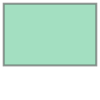

In [134]:
# Florida

min_lon = x_min = -89
max_lon = x_max = -74
min_lat = y_min = 22
max_lat = y_max = 32

bbox=[min_lon, max_lon, min_lat, max_lat]
bbox

florida = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max), (x_min,y_min)])

In [10]:
mask_lon = (sentinel_2b_gdf.lng >= min_lon) & (sentinel_2b_gdf.lng <= max_lon)
mask_lat = (sentinel_2b_gdf.lat >= min_lat) & (sentinel_2b_gdf.lat <= max_lat)

aoi = sentinel_2b_gdf.where(mask_lon & mask_lat).dropna()
aoi

,satellite,timestamp,coordinates,lng,lat,daytime,time_string
687,SENTINEL-2B,2024-07-12 16:34:41+00:00,POINT (-85.79488 31.86746),-85.794882,31.867457,True,2024-07-12 16:34:41
688,SENTINEL-2B,2024-07-12 16:34:56+00:00,POINT (-86.04003 30.98383),-86.040033,30.983833,True,2024-07-12 16:34:56
689,SENTINEL-2B,2024-07-12 16:35:11+00:00,POINT (-86.28186 30.09984),-86.281856,30.099836,True,2024-07-12 16:35:11
690,SENTINEL-2B,2024-07-12 16:35:26+00:00,POINT (-86.52052 29.21548),-86.520522,29.215481,True,2024-07-12 16:35:26
691,SENTINEL-2B,2024-07-12 16:35:41+00:00,POINT (-86.75620 28.33078),-86.756195,28.330782,True,2024-07-12 16:35:41
692,SENTINEL-2B,2024-07-12 16:35:56+00:00,POINT (-86.98903 27.44576),-86.989030,27.445756,True,2024-07-12 16:35:56
693,SENTINEL-2B,2024-07-12 16:36:11+00:00,POINT (-87.21917 26.56042),-87.219173,26.560416,True,2024-07-12 16:36:11
694,SENTINEL-2B,2024-07-12 16:36:26+00:00,POINT (-87.44677 25.67478),-87.446766,25.674775,True,2024-07-12 16:36:26
695,SENTINEL-2B,2024-07-12 16:36:41+00:00,POINT (-87.67194 24.78885),-87.671941,24.788848,True,2024-07-12 16:36:41
696,SENTINEL-2B,2024-07-12 16:36:56+00:00,POINT (-87.89483 23.90265),-87.894827,23.902648,True,2024-07-12 16:36:56


Next, we can visualize these points on a map. They are color coded using a continuous color scale, with white being `now` and darker purple being further after `now`.

In [11]:
# This creates a range from 0-1 to define our colormap.
time_norm = (aoi.timestamp - t1) / (t2 - t1)

colors = apply_continuous_cmap(time_norm, Purples_9)

In [12]:
layer = ScatterplotLayer.from_geopandas(
    aoi,
    # extensions=[filter_extension],
    get_fill_color=colors,
    radius_min_pixels = 3
    # get_filter_value=filter_values,
    # filter_range=initial_filter_range,
)

m = Map(
    layer,
    basemap_style = basemap.CartoBasemap.DarkMatter,
    )
m

/opt/homebrew/lib/python3.10/site-packages/lonboard/_geoarrow/ops/reproject.py:23: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

We can clearly see the passes that Sentinel 2b takes in our area of interest and during our time frame.

---

## Calculating the position of a satellite constellation

Usually, humanitarians aren't concerned about which satellite captures an image, as long as they have a timely image with the appropriate resolution, (lack of) cloud cover, bands, etc.

The following example calculates the position of Planet satellites. With their portfolio's high spatial and temporal resolution, they are able to capture high-resolution images immediately before or after an event.

In [13]:
planet_url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=planet&FORMAT=tle"

planet_swarm = load.tle_file(planet_url, reload=True, filename="planet_swarm")
planet_swarm[0]

[#################################] 100% planet_swarm


<EarthSatellite SKYSAT-A catalog #39418 epoch 2024-07-11 13:15:24 UTC>

We then calculate the locations for all Planet satellites during our time frame in set increments.

In [14]:
timer = t1

rows = []

while timer <= t2:
    for sat in planet_swarm:
        timer, longitude, latitude, coords, daytime = location_iteration(timer, sat)

        row = pd.DataFrame({'satellite': sat.name, 'timestamp': timer, 'coordinates': [coords], 'lng': longitude, 'lat': latitude, 'daytime': daytime}, index=[0])
        rows.append(row)    

    timer += timedelta(minutes=3) # ~ 10 min

planet_swarm_df = pd.concat(rows, ignore_index=True)
planet_swarm_df["time_string"] = planet_swarm_df["timestamp"].dt.strftime('%Y-%m-%d %X')


In [15]:
planet_swarm_gdf = gpd.GeoDataFrame(planet_swarm_df, geometry="coordinates")

Again, we want to look at the satellites in our AOI. Because Planet satellites capture optical images, the following shows the next passes that occur when the satellite is lit (as a proxy of when the ground below is lit).

In [176]:
mask_lon = (planet_swarm_gdf.lng >= min_lon) & (planet_swarm_gdf.lng <= max_lon)
mask_lat = (planet_swarm_gdf.lat >= min_lat) & (planet_swarm_gdf.lat <= max_lat)

aoi_planet = planet_swarm_gdf.where(mask_lon & mask_lat).dropna()
aoi_planet_day = aoi_planet[aoi_planet.daytime == True]
aoi_planet_day[aoi_planet_day["timestamp"] > now]

planet_day = planet_swarm_gdf[planet_swarm_gdf.daytime == True]
planet_day[planet_day["timestamp"] > now]

,satellite,timestamp,coordinates,lng,lat,daytime,time_string
140,SKYSAT-A,2024-07-12 13:45:56+00:00,POINT (-54.61412 49.26839),-54.614123,49.268387,True,2024-07-12 13:45:56
142,SKYSAT-C1,2024-07-12 13:45:56+00:00,POINT (-48.16542 65.33420),-48.165423,65.334203,True,2024-07-12 13:45:56
143,SKYSAT-C4,2024-07-12 13:45:56+00:00,POINT (-83.51750 -44.62639),-83.517505,-44.626385,True,2024-07-12 13:45:56
144,SKYSAT-C5,2024-07-12 13:45:56+00:00,POINT (67.45275 79.84514),67.452746,79.845144,True,2024-07-12 13:45:56
145,SKYSAT-C2,2024-07-12 13:45:56+00:00,POINT (-81.79363 -28.66329),-81.793627,-28.663289,True,2024-07-12 13:45:56
...,...,...,...,...,...,...,...
134534,FLOCK 4Q-2,2024-07-14 13:42:56+00:00,POINT (-41.38823 40.22216),-41.388230,40.222162,True,2024-07-14 13:42:56
134535,FLOCK 4Q-9,2024-07-14 13:42:56+00:00,POINT (-65.73982 -67.29934),-65.739819,-67.299338,True,2024-07-14 13:42:56
134537,FLOCK 4Q-4,2024-07-14 13:42:56+00:00,POINT (-58.36463 -54.51623),-58.364632,-54.516233,True,2024-07-14 13:42:56
134538,FLOCK 4Q-13,2024-07-14 13:42:56+00:00,POINT (-45.72142 14.59650),-45.721417,14.596497,True,2024-07-14 13:42:56


In [17]:
# This creates a range from 0-1 to define our colormap.
time_norm_planet = (aoi_planet_day.timestamp - t1) / (t2 - t1)

colors_planet = apply_continuous_cmap(time_norm_planet, Purples_9)

Let's visualize this with the same color scheme we used before.

In [158]:
layer2 = ScatterplotLayer.from_geopandas(
    aoi_planet_day,
    # extensions=[filter_extension],
    get_fill_color=colors_planet,
    radius_min_pixels = 3
    # get_filter_value=filter_values,
    # filter_range=initial_filter_range,
)

m2 = Map(
    layer2,
    basemap_style = basemap.CartoBasemap.DarkMatter,
    )
m2

/opt/homebrew/lib/python3.10/site-packages/lonboard/_geoarrow/ops/reproject.py:23: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

As expected, there are many more passes than by a single satellite. Due to small area of interests for many events, cloud cover, and other variables, a larger constellation lets practitioners then narrow down their search.

In reality, satellites are taking more images than the amount of time steps that we arbitrarily set. A line would better represent the path these satellites take. The area of capture of satellites also varies, which a point doesn't represent.

Once a satellite is calculated to have passed over an AOI, the next step could be to analyze the imagery, ideally using the other STAC and COG focused notebooks in this repository. Combining a positioning calculation with automated image loading and processing could be the foundations for a powerful EO-based monitoring and alerting system.

---

In [157]:
# # OLD

# paths = planet_swarm_gdf.groupby('satellite')['coordinates'].apply(lambda x: LineString(x.tolist()))
# paths = gpd.GeoDataFrame(paths, geometry='coordinates')
# paths = paths.reset_index()
# paths

In [203]:
def create_individual_linestrings(coords, timestamps, time_strings):
    coords_list = coords.tolist()
    timestamps_list = timestamps.tolist()
    time_strings_list = time_strings.tolist()
    line_segments = [
        {'linestring': LineString([coords_list[i], coords_list[i + 1]]), 'timestamp': timestamps_list[i], 'time_string': time_strings_list[i]} 
        for i in range(len(coords_list) - 1)
    ]
    return line_segments

In [204]:
new_rows = []

for satellite, group in planet_day.groupby('satellite'):
    line_segments = create_individual_linestrings(group['coordinates'], group['timestamp'], group['time_string'])
    for segment in line_segments:
        new_rows.append({'satellite': satellite, 'linestring': segment['linestring'], 'timestamp': segment['timestamp'], 'time_string': segment['time_string']})

path_segments = gpd.GeoDataFrame(new_rows, geometry='linestring')
path_segments

,satellite,linestring,timestamp,time_string
0,FLOCK 4Q-1,"LINESTRING (125.05396 44.07497, 120.73349 55.2...",2024-07-12 13:42:56+00:00,2024-07-12 13:42:56
1,FLOCK 4Q-1,"LINESTRING (120.73349 55.23907, 113.62825 66.1...",2024-07-12 13:45:56+00:00,2024-07-12 13:45:56
2,FLOCK 4Q-1,"LINESTRING (113.62825 66.19955, 97.21338 76.49...",2024-07-12 13:48:56+00:00,2024-07-12 13:48:56
3,FLOCK 4Q-1,"LINESTRING (97.21338 76.49829, 38.93100 82.58273)",2024-07-12 13:51:56+00:00,2024-07-12 13:51:56
4,FLOCK 4Q-1,"LINESTRING (38.93100 82.58273, -18.85540 76.41...",2024-07-12 13:54:56+00:00,2024-07-12 13:54:56
...,...,...,...,...
84631,SKYSAT-C9,"LINESTRING (4.38638 -35.66845, 1.01111 -46.98783)",2024-07-14 13:12:56+00:00,2024-07-14 13:12:56
84632,SKYSAT-C9,"LINESTRING (1.01111 -46.98783, -3.77353 -58.17...",2024-07-14 13:15:56+00:00,2024-07-14 13:15:56
84633,SKYSAT-C9,"LINESTRING (-3.77353 -58.17996, -12.23310 -69....",2024-07-14 13:18:56+00:00,2024-07-14 13:18:56
84634,SKYSAT-C9,"LINESTRING (-12.23310 -69.09711, -34.68493 -78...",2024-07-14 13:21:56+00:00,2024-07-14 13:21:56


In [205]:
def is_within_aoi(linestring, florida):
    return linestring.intersects(florida)

In [206]:
path_segments['within_aoi'] = path_segments['linestring'].apply(lambda x: is_within_aoi(x, florida))
path_segments_clipped = path_segments[path_segments['within_aoi']].drop(columns='within_aoi')

path_segments_clipped['length'] = path_segments_clipped['linestring'].apply(lambda x: x.length)

path_segments_clipped = path_segments_clipped[path_segments_clipped["length"] <= 75].drop(columns='length')

In [207]:
viz(path_segments_clipped[path_segments_clipped["satellite"] == "SKYSAT-C16"])

/opt/homebrew/lib/python3.10/site-packages/lonboard/_geoarrow/ops/reproject.py:23: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

In [208]:
# This creates a range from 0-1 to define our colormap.
time_norm_planet_swarm = (path_segments_clipped.timestamp - t1) / (t2 - t1)

colors_planet_swarm = apply_continuous_cmap(time_norm_planet_swarm, Oranges_9)
colors_planet_swarm
len(colors_planet_swarm)

380

In [211]:
layer3 = PathLayer.from_geopandas(
    path_segments_clipped,
    # get_color=[255, 255, 255],
    get_color = colors_planet_swarm,
    get_width=6200,
    opacity=.05,
    auto_highlight=True
)

/opt/homebrew/lib/python3.10/site-packages/lonboard/_geoarrow/ops/reproject.py:23: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


In [212]:
m3 = Map(
    [layer3],
    basemap_style = basemap.CartoBasemap.DarkMatter,
    )
m3

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…